# 2-4-1 Textual Inversion

[An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion](http://arxiv.org/abs/2208.01618)

## 0 章节目标

* 理解 Textural Inversion 的基本思想
* 学习如何使用 Huggingface 的代码微调自己的模型

## 1 问题背景

Textual Inversion 仅需要用户提供 3~5 张含有某个特定概念 $S^*$ 的图片（既可以是某个主体，也可以是某种风格），就可以结合扩散模型的先验知识进行创作，将这个新的概念 $S^*$ 融合进生成的图片中。

![](https://textual-inversion.github.io/static/images/editing/teaser.JPG)

在大模型中引入新的概念通常是很困难的：对每一个新概念 Fine tuning 整个模型成本太高，且当新概念的示例个数较少时，Fine tuning 会面临灾难性遗忘的问题。一种改进的办法是冻结大模型本身，并训练一个 Adapter，但这并不能完全解决灾难性遗忘，且难以同时处理新学习的概念与原始先验同时出现的情形。

Textual Inversion 旨在为新的概念学习一个新的 embedding。如此一来，这个新概念可以被视为一个伪词（pseudo-word），它在生成过程中与其他一般的单词扮演相同的角色。这么做的一个好处是，Textual Inversion 的微调没有修改生成模型本身，因此模型不会失去丰富的文本理解和泛化能力。

## 2 微调方法

Textural Inversion 的实现建立在 Latent Diffusion Models（[LDM](https://arxiv.org/abs/2112.10752)）之上，其包括两个部分：自编码器和扩散模型。自编码器的 Encoder 将 $x$ 映射为隐空间中的 $z=\mathcal{E}(x)$，而 Decoder 将其映射回原空间：$D(\mathcal{E})\approx x$。自编码器事先通过 KL 散度或矢量量化的方法预训练好，随后在扩散模型中，就从隐空间的 $z_t$ 开始对图形进行去噪重建。因此，目标函数由：
$$
L_{DM}=\mathbb{E}_{x,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( x,t \right) \rVert _{2}^{2} \right] 
$$
变为：
$$
L_{LDM}:=\mathbb{E}_{z\sim \mathcal{E}\left( x \right) ,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( z_t,t \right) \rVert _{2}^{2} \right] 
$$
![](https://ommer-lab.com/wp-content/uploads/2022/08/article-Figure3-1-1536x762.png)
接下来引入条件机制，LDM的目标函数即：
$$
L_{LDM}:=\mathbb{E}_{z\sim \mathcal{E}\left( x \right) ,y,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( z_t,t,c_{\theta}\left( y \right) \right) \rVert _{2}^{2} \right] 
$$
Textual Inversion 为要学习的新概念设置了一个占位符 $S^*$，并干预 Encoder 计算嵌入的过程，学习得到嵌入向量 $v^∗$ 来替换与标记化字符串相关联的向量。通过这一方式，Textual Inversion 将新概念“注入”到了模型原有的词汇表中。

而为了学习这一嵌入向量 $v^*$，Textual Inversion 使用一个小型的图像集（通常为3~5张），用不同的 prompt 描述目标概念，通过最小化条件 LDM 扩散模型目标函数 $L_{LDM}$ 来找到 $v^∗$。这些 prompt 随机采样自 CLIP ImageNet 模板。

![](https://textual-inversion.github.io/static/images/training/training.JPG)

## 3 实验结果

![](https://textual-inversion.github.io/static/images/editing/bowl.JPG)
实验结果表明，Textual Inversion 相比普通的图像生成模型（如 DALL·E-2，LDM），可以更好地捕捉新概念的独特细节（如碗的色调、花纹），同时保留模型本身的先验（如保留了“碗可以盛放其他物体”的先验知识）。它与先前的一些模型（如 PALAVRA）不一样的地方在于，PALAVRA 等模型只学到了用来区分两种概念的特征，而 Textual Inversion 则能够生成这些独特的特征。

同时 Textural Inversion 具备风格迁移的能力，这意味着待学习的新概念不局限于一个具体的主体概念，也可以是某种抽象的概念。在这一点上，其很接近的研究 DreamBooth 似乎并不具备（*待验证*）。而且由于 Textural Inversion 的方案中，新概念在隐空间中就相当于一个普通的 token，所以可以同时对多个概念进行微调，在一个 prompt 内可以包括多个新的概念（DreamBooth 同样具备这种特点，对于这种类型的方案，在多个概念上分别微调模型似乎不会影响已经微调好的概念的生成效果）。

Textural Inversion 的这种方案不仅可以引入新的概念，同样也可以对已有概念进行修正，例如减少大模型本身具有的偏见。这可能也可被用来消除大模型对某一个概念的先验（[DA_Fusion](http://arxiv.org/abs/2302.07944)）。
![](https://textual-inversion.github.io/static/images/bias/bias.JPG)

更多实验结果请参考原论文和官方网站：[https://textual-inversion.github.io/](https://textual-inversion.github.io/)，

## 4 局限性
Textural Inversion 并不能很好地控制生成的新主体的形状，这也是因为，它并不是单纯地将新的主体“合成”进图片中。

此外，Textural Inversion 的微调时间很长。据论文作者称，学习一个新的概念大约需要两小时（2 x V100）。相比之下，DreamBooth 半个小时内就搞定了（1 x A100-PCIE）。

## 5 训练与推理

Hugging Face 提供了 Textural Inversion 的训练与推理代码，包括 [Python 版本](https://huggingface.co/docs/diffusers/training/text_inversion)、[Colab 版本（训练）](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb)和 [Colab版本（推理）](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb)。本教程以 Colab 的训练 Jupyter Notebook 为基础，提供了部分代码的注释，并探索了多概念 Prompt 的实际效果。

### 安装必要的库

我们推荐使用 Pytorch 2.0.1，选择非最新的版本对加速库 xformers 不友好（Pytorch 1.13.1 仅支持 xformers 0.0.16 且在某些显卡型号上无法使用），此外微调 Stable Diffusion 中的 UNet 时，使用 Pytorch 1.13.1 占用的显存（batch_size=2 需约 22G）远大于 Pytorch 2.0.1（batch_size=4 约 11G），原因不详。

In [1]:
!pip list | grep torch
!pip install accelerate diffusers transformers

# 非必要，您也可以选择不安装，使用较早版本的 Pytorch 时请使用 pip install xformers==0.0.16，注意别把 Pytorch 给卸了
!pip install xformers

### 前置工作

In [2]:
import itertools
import math
import os
import random

import PIL
import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from PIL import Image
from accelerate import Accelerator
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DPMSolverMultistepScheduler
)
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer


def image_grid(imgs, rows, cols):
    """
    将一组图像按照指定的行数和列数排列成网格。
    :param imgs: 包含图像的列表
    :param rows: 网格中的行数
    :param cols: 网格中的列数
    :return: 生成的图像网格
    """
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

#### 指定模型与要引入的概念

加载 Stable Diffusion 既可以使用 Huggingface 中的模型名 "stabilityai/stable-diffusion-2-1" 或其他版本，也可以将其下载到本地，如 "./models/stable-diffusion-2-1"。

concept 的图片可以在 [https://huggingface.co/sd-concepts-library/](https://huggingface.co/sd-concepts-library/midjourney-style) 下载，您也可以选择仓库中的其他 concept。

In [3]:
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1"
images_path = "../resource/2-4-1/Asgard"
# images_path = "../resource/2-4-1/midjourney-style"

##### 打印一下微调所用的图片

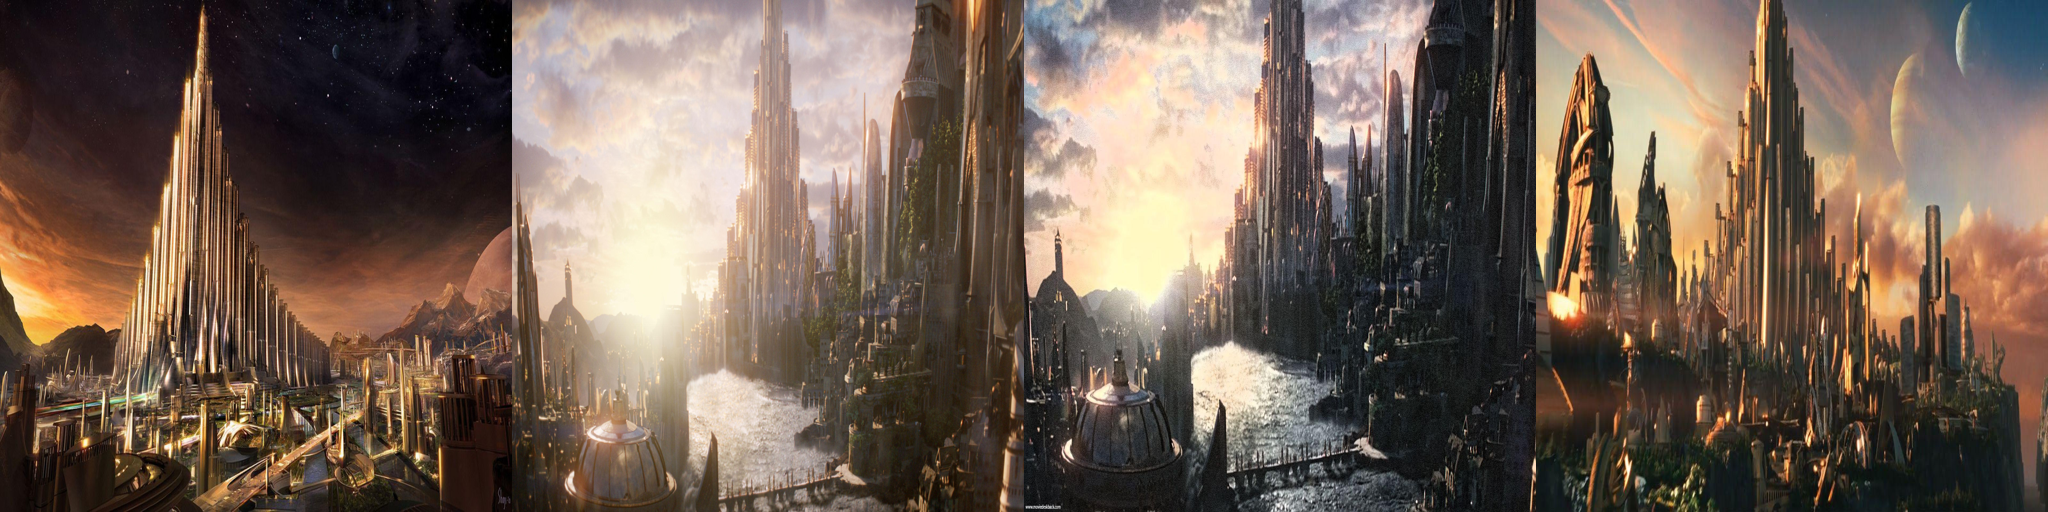

In [4]:
images = []
for file_path in os.listdir(images_path):
    try:
        image_path = os.path.join(images_path, file_path)
        images.append(Image.open(image_path).resize((768, 768)))
    except:
        print(
            f"{image_path} is not a valid image, "
            f"please make sure to remove this file from the directory otherwise the training could fail."
        )
image_grid(images, 1, len(images))

##### 概念相关设置

In [5]:
learnable_property = "object"  # 两种选择：object 学习一种新的主体，style 学习一种新的风格
# learnable_property = "style"  # 两种选择：object 学习一种新的主体，style 学习一种新的风格
placeholder_token = "<Asgard>"  # 占位符，用 <> 包裹，以免出现一些奇怪的问题
# placeholder_token = "<midjourney-style>"  # 占位符，用 <> 包裹，以免出现一些奇怪的问题
initializer_token = "building"  # 用一个单词描述您想要引入的新概念，模型在其基础上开始微调
# initializer_token = "fantasy"  # 用一个单词描述您想要引入的新概念，模型在其基础上开始微调

#### Prompt 模板
模板来自 CLIP ImageNet templates，object 和 style 各有一组，在训练时从中随机选取。

In [6]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

### 训练准备

#### 定义数据集

In [7]:
class TextualInversionDataset(Dataset):
    def __init__(
            self,
            root,
            tokenizer,
            learnable_property="object",
            placeholder_token="*",
            size=768,
            repeats=100,
            is_training=False,
            interpolation="bicubic",
            flip_p=0.5,
            center_crop=False,
    ):
        """
        Textural Inversion 数据集。
        :param root: 概念图片文件夹路径
        :param tokenizer: Stable Diffusion 的 tokenizer 对象
        :param learnable_property: 可学习概念的属性，["object", "style"]
        :param placeholder_token: 占位符的 token
        :param size: 图像尺寸
        :param repeats: 数据集扩充，训练时用来多次使用相同的数据样本
        :param is_training: 是否为训练数据集
        :param interpolation: 插值方法，["nearest", "bilinear", "bicubic", "lanczos"]
        :param flip_p: 随机水平翻转的概率
        :param center_crop: 是否对图像进行中心裁剪
        """
        self.root = root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.placeholder_token = placeholder_token
        self.size = size
        self.flip_p = flip_p
        self.center_crop = center_crop

        self.image_paths = [os.path.join(self.root, file_path) for file_path in os.listdir(self.root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if is_training:
            self._length = self.num_images * repeats

        self.interpolation = {
            "nearest": PIL.Image.NEAREST,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # 得分 SDE 默认流程
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = img.shape[0], img.shape[1]
            img = img[(h - crop) // 2: (h + crop) // 2, (w - crop) // 2: (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        # 翻转变换
        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        # 归一化
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

#### 加载模型

##### 载入 Tokenizer

载入后再使用 `add_tokens` 函数添加一个属于待学习概念的 token，如果返回值为 `0` 说明该 token 已经存在在 tokenizer 中，添加失败。用 <> 包裹特殊 token 一般可以避免这种问题。

In [8]:
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")

num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. "
        f"Please pass a different `placeholder_token` that is not already in the tokenizer."
    )

##### 计算占位符和初始单词的 token_id

注意区分：`token` 是字符串，如 `"toy"` 和 `"<cat-toy>"`，`token_id` 是 `int64` 的整数。

这里会检查 token 是否合法，必须是单个 token 而非 token 的序列。

In [9]:
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

##### 载入模型的其他部分

In [10]:
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet")

我们在 Stable Diffusion 的 `tokenizer` 中添加了一个新的 token（即 `placeholder_token`），对应增加了一个嵌入向量。

Embedding 在修改前后的形状为 `(49408, 1024)` 和 `(49409, 1024)`，为了更充分地利用 GPU 的张量核心，通过 `pad_to_multiple_of` 参数将其扩充至 $8$ 的整数倍。

关于 `pad_to_multiple_of` 的更多细节或取值选择可以参考：[https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc)

其实这个地方用不用这个技巧几乎没有任何影响，测试发现甚至没有给训练速度带来哪怕 0.01s/it 的提升。了解一下就行了。

In [11]:
text_encoder.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Embedding(49416, 1024)

记录一下现在的 Embedding 数目

In [12]:
num_embeddings = text_encoder.get_input_embeddings().num_embeddings

初始 `placeholder_token` 的 embedding 和 `initializer_token` 的相同。

In [13]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

##### 冻结绝大多数参数

Textural Inversion 只需要训练新加入进来的嵌入向量，其他模块的参数不参与训练。

In [14]:
def freeze_params(params):
    """
    冻结指定参数。
    :param params: Module.parameters
    """
    for param in params:
        param.requires_grad = False


# 冻结 VAE 和 UNet 的所有参数
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# 冻结 Text Encoder 除 Token Embedding 之外的所有参数
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

#### 实例化 Dataset 和 Dataloader

In [15]:
train_dataset = TextualInversionDataset(
    root=images_path,
    tokenizer=tokenizer,
    learnable_property=learnable_property,
    placeholder_token=placeholder_token,
    size=vae.config.sample_size,
    repeats=100,
    is_training=True,
)

In [16]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

#### 实例化噪声

In [17]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")

### 训练

#### 超参数配置

如果您对结果不满意，调整 `learning_rate`、`train_batch_size` 和 `max_train_steps` 可能有用。

如果您的显存不够大，可以适当调小 `train_batch_size`。不同 `train_batch_size` 对应的最优 `learning_rate` 和 `max_train_steps` 可能是不同的。您也可以通过修改 `gradient_accumulation_steps` 来间接达到增大 batch_size 的效果。

`gradient_checkpointing` 同样有助于节省显存，它的作用是不保存整个计算图的所有中间激活值，而是在反向传播时重新计算，以牺牲一定训练速度的方式节省显存（我们在 2080Ti 下进行了测试：启用 gradient checkpointing 后，显存占用从 12G 降为 9G，同时每个 iteration 训练时长增加了 0.22s）。

`mixed_precision` 启用混合精度，在较新的显卡中进行训练可以带来很大的训练速度提升。通过 `accelerate config` 在全局进行设置。从默认的全精度 `fp32` 变为 `fp16`，显存可以降低一半，同时有论文指出可以带来 2~8 倍的性能提升。`fp8` 和 `bf16` 也是可选项，但并非所有的显卡或训练环境都支持。

In [18]:
output_dir = "sd-concept-output"
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 500,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": False,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": output_dir,
}

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 训练函数

In [19]:
def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    """保存训练结果。"""
    print("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)


def training_function(text_encoder, vae, unet):
    """训练函数。"""
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes

    # 优化器，只优化 Embedding 参数
    optimizer = torch.optim.AdamW(text_encoder.get_input_embeddings().parameters(), lr=learning_rate)

    text_encoder, optimizer, train_dataloader = accelerator.prepare(text_encoder, optimizer, train_dataloader)

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # VAE 不用训练，设为 eval 模式
    vae.eval()
    # UNet 也不用训练，但为了使用 gradient_checkpointing 功能，仍需留在 train 模式
    unet.train()

    # 使用了 gradient_accumulation_steps 则需要重新计算实际上的训练 step 和 epoch 数
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Instantaneous batch size per device = {train_batch_size}")
    print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    print(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    print(f"  Total optimization steps = {max_train_steps}")

    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # 先将图片 Encode 至 latent space
                vae.encode(batch["pixel_values"].to(dtype=weight_dtype))
                vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # 采样噪声
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # 为每个图片随机取一个时间步
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,),
                                          device=latents.device).long()
                # 根据该时间步的噪声水平向 latent space 中加噪
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # 获取文本条件的 embedding
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # 预测噪声残差
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                # scheduler 根据 prediction type 确定预测 target
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # 仅 placeholder_token 正样本
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                index_grads_to_zero = torch.arange(num_embeddings) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # sync_gradients 指示目前梯度是否在所有进程中被同步，若同步，完成一次梯度更新。在分布式训练中才用得到
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()

    # 保存模型
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # 保存学习到的 embedding
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

#### 开始训练！

In [20]:
accelerate.notebook_launcher(training_function, num_processes=1, args=(text_encoder, vae, unet))

# 释放空间
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad
    torch.cuda.empty_cache()

Launching training on one GPU.
***** Running training *****
  Num examples = 400
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2000


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/guapiii/anaconda3/envs/pytorch201/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Saving embeddings
Saving embeddings
Saving embeddings
Saving embeddings


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Saving embeddings


### 模型推理

#### 加载原始模型

In [21]:
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    scheduler=DPMSolverMultistepScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

#### 加载新概念的 embedding

您也可以通过 `pipe.load_textual_inversion("sd-concepts-library/cat-toy")` 或其他语句加载在线的模型。但不同版本的 embedding 文件不通用，这些通常用于 1-4 或 1-5 版本。

前面训练的时候为了利用上 Tensor Cores 将 token_embedding 的维度设置为了 $8$ 的倍数，但实际上这里每次只加了一个 token，所以执行以下语句时维度只会加 $1$。

Textural Inversion 可以往模型中加入不止一个概念，以下演示的是加入一个 object 和一个 style 的结果，训练好的 Embedding 在 [resource/2-4-1/learned_embeds](../resource/2-4-1/learned_embedding) 中。

In [22]:
pipe.load_textual_inversion("../resource/2-4-1/learned_embedding/Asgard.bin")
pipe.load_textual_inversion("../resource/2-4-1/learned_embedding/midjourney-style.bin")

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49410. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

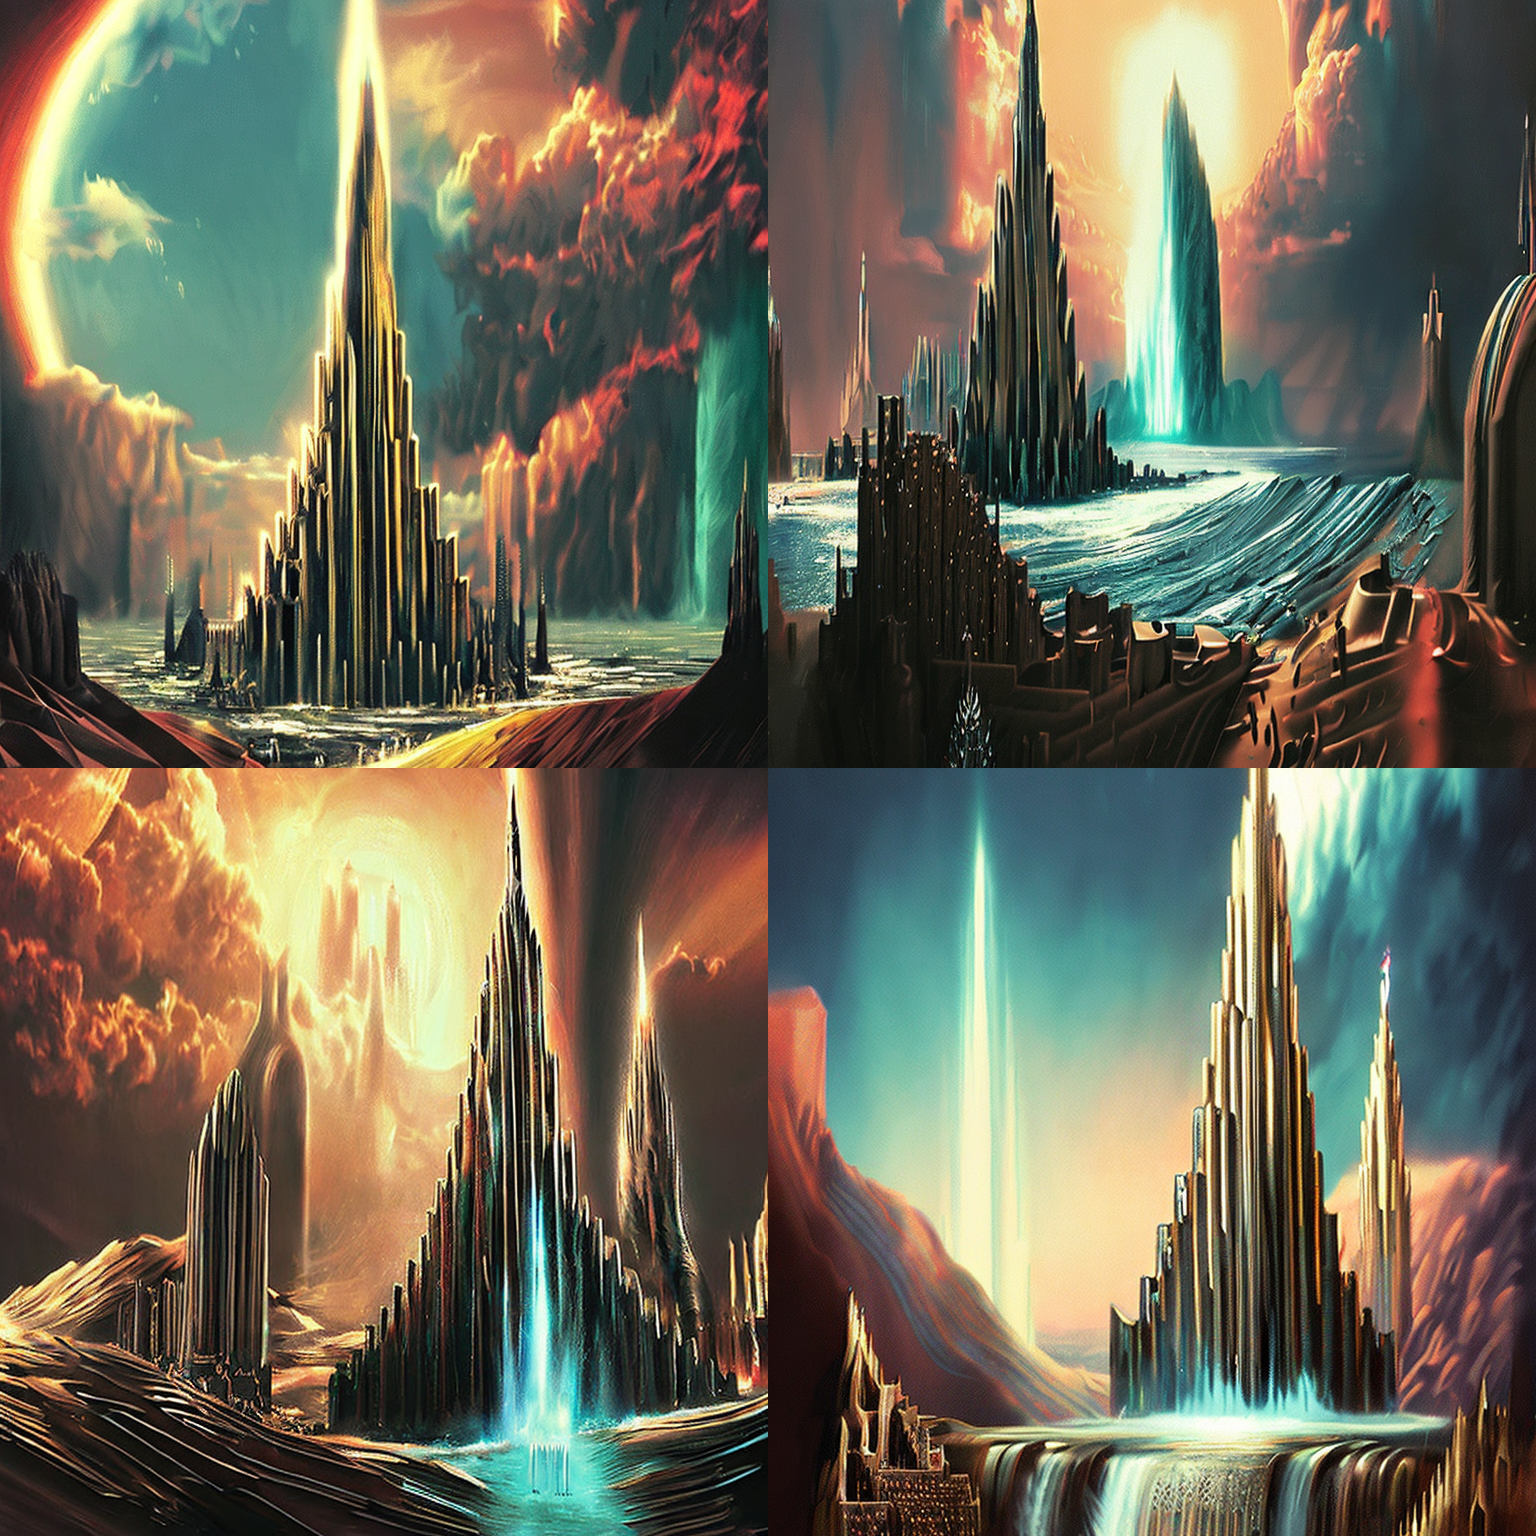

In [23]:
prompt = "<Asgard> in the style of <midjourney-style>"

num_samples = 2
num_rows = 2

all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid